---

#Clasificación de género usando OpenCV y Keras

---


Se instalan las librerías a utilizar

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPool2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

A continuación conectaremos con google drive para poder usar el dataset para entrenar nuestro modelo e importarlo de forma más eficiente.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se descomprime el dataset el cual se encuentra comprimido en ZIP

In [ ]:
!unzip '/content/drive/MyDrive/DatasetFaces.zip' -d "Dataset"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/male/067031.jpg.jpg  
  inflating: Dataset/Validation/male/067038.jpg.jpg  
  inflating: Dataset/Validation/male/067040.jpg.jpg  
  inflating: Dataset/Validation/male/067046.jpg.jpg  
  inflating: Dataset/Validation/male/067048.jpg.jpg  
  inflating: Dataset/Validation/male/067054.jpg.jpg  
  inflating: Dataset/Validation/male/067064.jpg.jpg  
  inflating: Dataset/Validation/male/067068.jpg.jpg  
  inflating: Dataset/Validation/male/067069.jpg.jpg  
  inflating: Dataset/Validation/male/067086.jpg.jpg  
  inflating: Dataset/Validation/male/067091.jpg.jpg  
  inflating: Dataset/Validation/male/067099.jpg.jpg  
  inflating: Dataset/Validation/male/067101.jpg.jpg  
  inflating: Dataset/Validation/male/067102.jpg.jpg  
  inflating: Dataset/Validation/male/067112.jpg.jpg  
  inflating: Dataset/Validation/male/067117.jpg.jpg  
  inflating: Dataset/Validation/male/067119.jpg.jpg  
  inflating: Dataset/Validation

Podemos comprobar los diferentes tipos de imagenes que se encuentran en nuestro dataset el cual en este caso se basa en la clasificación de género

In [ ]:
traindir = "Dataset/Training"
testdir = "Dataset/Validation"
os.listdir(traindir)

['male', 'female']

La función show_images nos mostrará de manera aleatoria 10 de imágenes del género especificado sacadas del los archivos de entrenamiento de nuestro modelo

In [ ]:
def show_images(dir):
    plt.figure(figsize=(12,7))
    for i in range(10):
        plt.subplot(2,5,i+1)
        img = random.choice(os.listdir(dir))
        img = load_img(os.path.join(dir,img))
        plt.subplots_adjust(hspace=0.2)
        x =dir.split("/")[-1]
        if x == "male":
            plt.suptitle("Male Images",fontsize=15)
        else:
            plt.suptitle("Female Images",fontsize=15)
        plt.imshow(img)
    plt.tight_layout()

Aqui se nos muestra 10 imágenes del dataset de imágenes de hombres

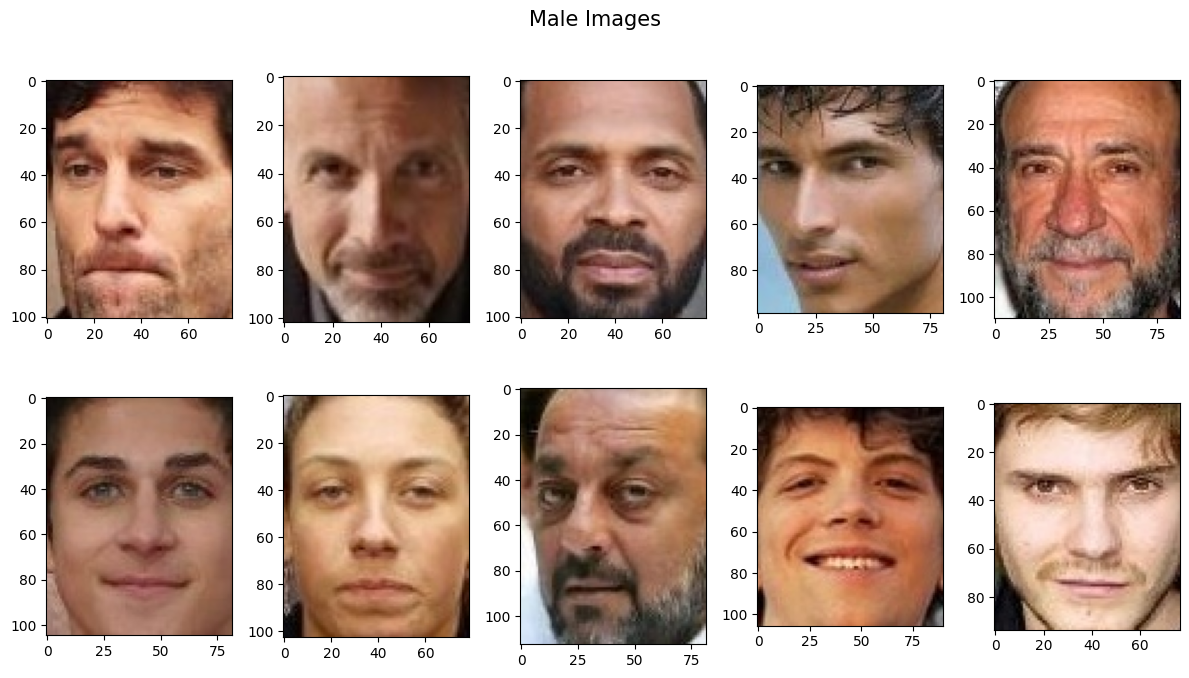

In [ ]:
show_images("Dataset/Training/male")

Aquí podemos comprobar el dataset de imágenes de mujeres

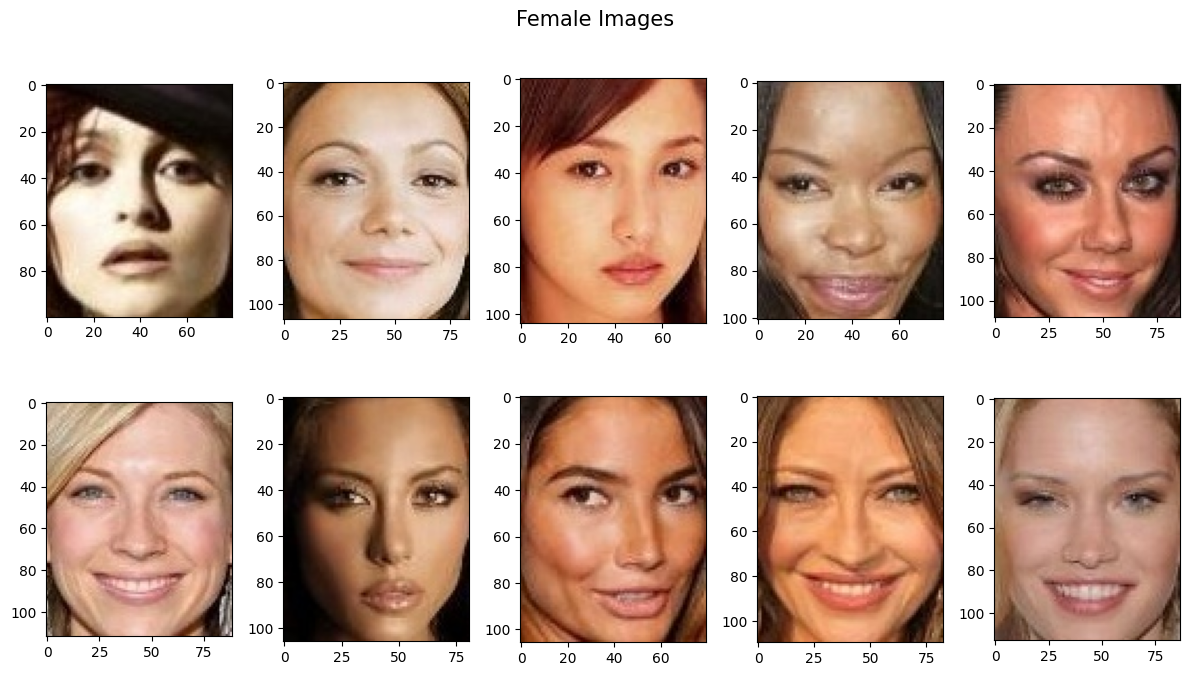

In [ ]:
show_images("Dataset/Training/female")


La siguiente parte del código configura generadores de datos para el entrenamiento y la evaluación de un modelo de red neuronal convolucional posteriormente explicaremos de manera mas a fondo el código

In [ ]:
height = 160
width = 160
ratio = 1/255.0
zoom = 0.2

print("---Train Data---")
datagen =  ImageDataGenerator(rescale = ratio, rotation_range=45, height_shift_range=0.2, shear_range=0.2,
                              zoom_range=zoom, validation_split=0.2, horizontal_flip=True)
train_data = datagen.flow_from_directory(directory = traindir, target_size=(height,width),
                                               class_mode = "categorical", batch_size=32,subset="training")

print("---Validation Data---")
val_data = datagen.flow_from_directory(directory = traindir, target_size=(height,width),
                                               class_mode = "categorical",batch_size=32,subset="validation")

print("---Test Data---")
datagen2 =  ImageDataGenerator(rescale = ratio, rotation_range=45, height_shift_range=0.2, shear_range=0.2,
                              zoom_range=zoom, validation_split=0, horizontal_flip=True)
test_data = datagen2.flow_from_directory(directory = testdir, target_size=(height,width),
                                               class_mode = "categorical", batch_size=32)

---Train Data---
Found 37608 images belonging to 2 classes.
---Validation Data---
Found 9401 images belonging to 2 classes.
---Test Data---
Found 11649 images belonging to 2 classes.


Comenzamos determinando las dimensiones objetivo de las imágenes, la relación de escala y el zoom que se hara sobre la imagen en el procesamiento de la misma usando height, width, ratio, zoom

Se crea un generador de datos para el conjunto de entrenamiento con aumentación de datos. La aumentación incluye reescalamiento, rotación, cambio de altura, cambio de inclinación, zoom y volteo horizontal. Al realizar esto se hace más sencilla la tarea de diversificar el conjunto de entrenamiento y mejorar la capacidad del modelo para generalizar.

A continuación se importará la arquitectura MobileNetV2 el cual es un modelo de red neuronal convolucional preentrenada en grandes conjuntos de datos de imágenes para tareas de clasificación.

In [ ]:
#Importamos modelo convolucional preentrenado de keras para clasificación
#de imágenes
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
mobilenet = MobileNetV2(weights = "imagenet", include_top = False, input_shape=(height,width,3))

#Hacemos las capas no entrenables
for layer in mobilenet.layers:
    layer.trainable = False

Continuamos creando ya definitivamente el modelo de clasificación de género facial utilizando transferencia de aprendizaje con MobileNetV2.

La capa densa después de MobileNetV2 permite adaptar características específicas a la tarea de clasificación binaria de género. Se utiliza la función de activación ReLU para introducir no linealidades. La capa de salida tiene activación softmax para obtener probabilidades de dos clases (género masculino y femenino).

El modelo se compila con el optimizador Adam y se utiliza la función de pérdida categorical_crossentropy para la clasificación multiclase. La métrica de precisión se supervisa durante el entrenamiento.

In [ ]:
model = Sequential()
model.add(mobilenet)
model.add(Dense(128,activation="relu"))
model.add(Flatten())
model.add(Dense(2,activation = "softmax"))

model.compile(optimizer=Adam(learning_rate=0.001),loss = "categorical_crossentropy",metrics =["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 dense_2 (Dense)             (None, 5, 5, 128)         163968    
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 6402      
                                                                 
Total params: 2428354 (9.26 MB)
Trainable params: 170370 (665.51 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________



Establecemos una tecnica de regularización la cual guarda el modelo con la mejor precisión del conjunto de validación.

Por otro lado usamos EarlyStopping para que se detenga el entrenamiento si no hay mejoras tras 5 epochs lo que nos permitirá evitar un sobreentranmiento.

In [ ]:
checkpoint = ModelCheckpoint("ModeloClasificacionGenero.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

Comenzamos a entrenar nuestro modelo usando las técnicas establecidas previamente de checkpoint y earlystopping y diviendiendo los datos en lotes de 32 a la hora de entrenarlos.

In [ ]:
batch_size = 32
history = model.fit(train_data,steps_per_epoch = len(train_data)// batch_size,epochs=15,
                              validation_data = val_data,validation_steps = len(val_data)//batch_size,
                              callbacks = [checkpoint,earlystop],verbose=1)

Epoch 1/15
36/36 [==============================] - ETA: 0s - loss: 0.7459 - accuracy: 0.6884
Epoch 1: val_accuracy improved from -inf to 0.85417, saving model to ModeloClasificacionGenero.h5
36/36 [==============================] - 56s 1s/step - loss: 0.7459 - accuracy: 0.6884 - val_loss: 0.3880 - val_accuracy: 0.8542
Epoch 2/15
36/36 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.7960
Epoch 2: val_accuracy did not improve from 0.85417
36/36 [==============================] - 40s 1s/step - loss: 0.4420 - accuracy: 0.7960 - val_loss: 0.3737 - val_accuracy: 0.8438
Epoch 3/15
36/36 [==============================] - ETA: 0s - loss: 0.4047 - accuracy: 0.8264
Epoch 3: val_accuracy did not improve from 0.85417
36/36 [==============================] - 39s 1s/step - loss: 0.4047 - accuracy: 0.8264 - val_loss: 0.4151 - val_accuracy: 0.8090
Epoch 4/15
36/36 [==============================] - ETA: 0s - loss: 0.4094 - accuracy: 0.8255
Epoch 4: val_accuracy improved from 0

Procedemos a comprobar los resultados de nuestro modelo

In [ ]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

294/294 [==============================] - 280s 947ms/step - loss: 0.3055 - accuracy: 0.8712
Validation Loss: 0.3055475950241089, Validation Accuracy: 0.8711839318275452


Como se puede apreciar nuestro modelo ha conseguuido una gran precisión de hasta un 87%, lo cual nos da a entender que puede clasificar el género de la persona con una alta probabiidad de acierto.

Por otro lado la pérdida llega a alcanzar hasta un 30% lo cual puede deberse a varias razones. Una de estas razones puede ser la diferencia en la cantidad de imagenes con la que hemos entrenado a nuestro modelo mientras que otra de las razones puede llegar a ser que el modelo no este capturando ciertos patrones iportantes de los datos que nos ayudarían en gran medida a clasificarlos.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Validation Loss: {test_loss}, Validation Accuracy: {test_accuracy}')

365/365 [==============================] - 331s 906ms/step - loss: 0.3115 - accuracy: 0.8684
Validation Loss: 0.31150707602500916, Validation Accuracy: 0.8684006929397583


A la hora de probar el modelo con los datos de prueba podemos comprobar como los resultados tienen una gran variación respecto al resultado de los datos de entrenamiento variando unicamente un 0.05% en la precisión y en la pérdida de imformación.

In [ ]:
def checking(img):
    label = {0: "female", 1: "male"}
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = cascade.detectMultiScale(gray, 1.1, 7)

    for x, y, w, h in faces:
        face = image[y:y+h, x:x+w]

        # Preserve aspect ratio while resizing
        aspect_ratio = float(w) / float(h)
        new_width = 160
        new_height = int(new_width / aspect_ratio)
        face_resized = cv2.resize(face, (new_width, new_height))

        img_scaled = face_resized / 255.0
        reshape = np.reshape(img_scaled, (1, new_height, new_width, 3))
        img = np.vstack([reshape])
        result = np.argmax(model.predict(img), axis=-1)

        if result == 0:
            cv2.rectangle(image, (x-10, y), (x+w, y+h), (255, 0, 0), 4)
            cv2.rectangle(image, (x-10, y-50), (x+w, y), (255, 0, 0), -1)
            cv2.putText(image, label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)

        elif result == 1:
            cv2.rectangle(image, (x-10, y), (x+w, y+h), (0, 0, 255), 4)
            cv2.rectangle(image, (x-10, y-50), (x+w, y), (0, 0, 255), -1)
            cv2.putText(image, label[1], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

En la función checking mostrada anteriormente se realiza la detección de caras en una imagen utilizando el clasificador de cascada Haar para identificar las ubicaciones de las caras. Luego, para cada cara detectada, redimensiona la región de la cara a un tamaño específico, normaliza los valores de píxeles a un rango de 0 a 1 y realiza una predicción utilizando el modelo entrenado anteriormente. Dependiendo de la clase predicha, dibuja un rectángulo alrededor de la cara con un mensaje indicando el género predicho.

1/1 [==============================] - 0s 229ms/step


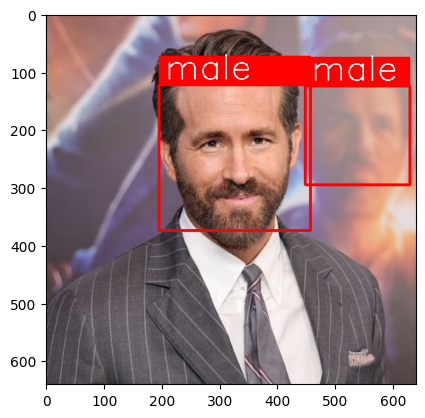

In [ ]:
checking("ryan.jpeg")

Al realizar pruebas con nuestro clasificador y detector de caras podemos comprobar como no reconoce unicamente la cara principal que se muestra en la imagen sino que también es capaz de detectar y clasificar de manera correcta una cara que podemos apreciar en el fondo de la imagen.

1/1 [==============================] - 0s 124ms/step


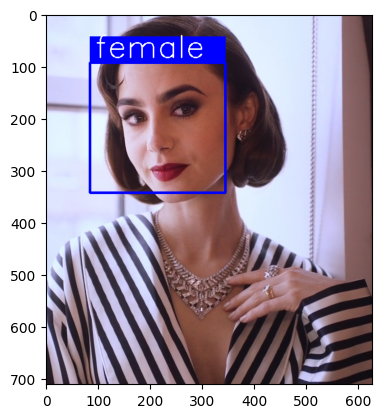

In [ ]:
checking("lily.jpeg")

1/1 [==============================] - 0s 46ms/step


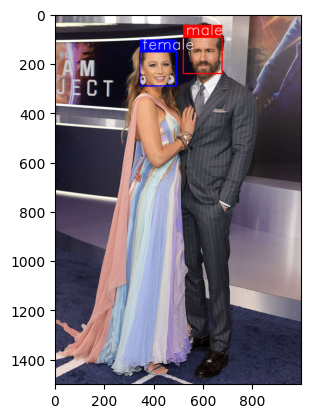

In [ ]:
checking("couple.jpeg")

1/1 [==============================] - 0s 38ms/step


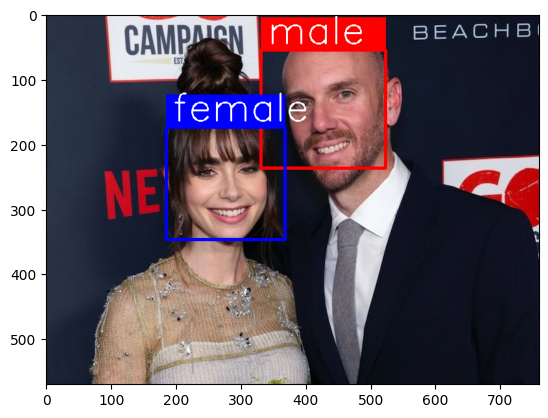

In [ ]:
checking("couple2.jpeg")

Con los diversos ejemplos mostrados comprobamos que nuestro clasificador es capaz de detectar de manera correcta las diversas caras en imágenes y clasificarlas como hombre o mujer